In [8]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import pickle
import json
from pathlib import Path
import os
from sklearn.model_selection import RandomizedSearchCV
import optuna

In [2]:
script_dir = os.getcwd()
data_dir = Path(script_dir).parent / "data"
model_dir = Path(script_dir).parent / "models"

In [3]:
# Load the preprocessed data
X_train = np.load(f'{data_dir}/X_train_final.npy')
X_val = np.load(f'{data_dir}/X_val_final.npy')
X_test = np.load(f'{data_dir}/X_test_final.npy')

y_train_log = np.load(f'{data_dir}/y_train_log.npy')  # Log-transformed version!
y_val_log = np.load(f'{data_dir}/y_val_log.npy')
y_test_log = np.load(f'{data_dir}/y_test_log.npy')

# Basic Run

In [5]:
model = xgb.XGBRegressor(
    n_estimators=1000,           # Number of trees
    learning_rate=0.1,          # Step size shrinkage (eta)
    max_depth=7,                 # Maximum tree depth
    min_child_weight=5,          # Minimum sum of instance weight in a child
    subsample=0.8,               # Fraction of samples for each tree
    colsample_bytree=1.0,        # Fraction of features for each tree
    gamma=0.1,                     # Minimum loss reduction for split
    reg_alpha=0.1,               # L1 regularization
    reg_lambda=1.0,              # L2 regularization
    random_state=42,
    n_jobs=-1,  
    device='cuda',                # Use all CPU cores
    #early_stopping_rounds=50,    # Stop if no improvement for 50 rounds
    eval_metric='mphe'          # Evaluation metric
)

In [39]:

model.fit(
    X_train, y_train_log,
    eval_set=[(X_train, y_train_log), (X_val, y_val_log)],
    verbose=50  # Print every 50 iterations
)

[0]	validation_0-mphe:0.37157	validation_1-mphe:0.37175
[50]	validation_0-mphe:0.01759	validation_1-mphe:0.01823
[100]	validation_0-mphe:0.01424	validation_1-mphe:0.01507
[150]	validation_0-mphe:0.01329	validation_1-mphe:0.01449
[200]	validation_0-mphe:0.01267	validation_1-mphe:0.01436
[250]	validation_0-mphe:0.01215	validation_1-mphe:0.01450
[300]	validation_0-mphe:0.01187	validation_1-mphe:0.01460
[350]	validation_0-mphe:0.01163	validation_1-mphe:0.01469
[400]	validation_0-mphe:0.01147	validation_1-mphe:0.01476
[450]	validation_0-mphe:0.01131	validation_1-mphe:0.01482
[500]	validation_0-mphe:0.01118	validation_1-mphe:0.01492
[550]	validation_0-mphe:0.01107	validation_1-mphe:0.01499
[600]	validation_0-mphe:0.01099	validation_1-mphe:0.01503
[650]	validation_0-mphe:0.01089	validation_1-mphe:0.01507
[700]	validation_0-mphe:0.01082	validation_1-mphe:0.01512
[750]	validation_0-mphe:0.01074	validation_1-mphe:0.01515
[800]	validation_0-mphe:0.01067	validation_1-mphe:0.01522
[850]	validation_

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,1.0
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",'cuda'
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabete

In [40]:
y_train_pred_log = model.predict(X_train)
y_val_pred_log = model.predict(X_val)
y_test_pred_log = model.predict(X_test)

# Convert back to original price scale
y_train_actual = np.expm1(y_train_log)
y_train_pred = np.expm1(y_train_pred_log)

y_val_actual = np.expm1(y_val_log)
y_val_pred = np.expm1(y_val_pred_log)

In [10]:
def calculate_metrics(y_true, y_pred, dataset_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n{dataset_name} Metrics:")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  MAE:  ${mae:,.2f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape}

train_metrics = calculate_metrics(y_train_actual, y_train_pred, "Training")
val_metrics = calculate_metrics(y_val_actual, y_val_pred, "Validation")


Training Metrics:
  RMSE: $1,644.42
  MAE:  $492.44
  R²:   0.9613
  MAPE: 8.59%

Validation Metrics:
  RMSE: $2,277.40
  MAE:  $654.05
  R²:   0.9252
  MAPE: 11.20%


# Cross Validation Random Search

In [25]:
param_dist = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1, 0.5, 1],
    'n_estimators': [500, 1000]
}

# Initialize the model
xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)

# Set up the search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,           # Number of combinations to try
    scoring='neg_mean_squared_error',
    cv=3,                # 3-fold cross-validation
    verbose=1,
    random_state=42
)

# Fit the search
random_search.fit(X_train, y_train_log)

print(f"Best Parameters: {random_search.best_params_}")
best_model = random_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}


# Optuna Hyperparameter Tuning

In [6]:
def objective(trial):
    # 1. Define the Expanded Parameter Space
    param = {
        # GPU Acceleration
        'tree_method': 'hist',
        'device': 'cuda',  # Use 'gpu' if using an older version of XGBoost
        
        # Core Hyperparameters
        'n_estimators': 2000, # Set high, let early stopping handle the rest
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        
        # Regularization (To fix your overfitting)
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        
        # Sampling
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        
        'random_state': 42,
        'early_stopping_rounds': 50
    }

    # 2. Initialize and Fit
    model = xgb.XGBRegressor(**param, eval_metric='mphe')
    
    # We use the log-transformed data directly for tuning speed
    model.fit(
        X_train, y_train_log,
        eval_set=[(X_val, y_val_log)],
        verbose=False
    )

    # 3. Evaluate on Validation Set
    preds = model.predict(X_val)
    preds = np.expm1(preds)  # Convert back to original scale
    y_val = np.expm1(y_val_log)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    mape = np.mean(np.abs((y_val - preds) / y_val)) * 100
    
    return mape

# 4. Create and Run the Study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True) # Start with 100 trials

print("\n--- Optimization Finished ---")
print(f"Best RMSE: {study.best_value:.4f}")
print(f"Best Params: {study.best_params}")

[I 2026-01-17 19:13:42,281] A new study created in memory with name: no-name-30360e25-afca-4738-9b9e-3d519e2809c3


  0%|          | 0/100 [00:00<?, ?it/s]

/home/amit.ru/miniconda3/envs/dl_project/lib/python3.12/site-packages/xgboost/core.py:774: UserWarning: [19:13:44] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[I 2026-01-17 19:13:44,668] Trial 0 finished with value: 12.413008348761576 and parameters: {'learning_rate': 0.019156309004348837, 'max_depth': 3, 'min_child_weight': 16, 'gamma': 7.553874233202535e-08, 'reg_alpha': 0.03873920716655337, 'reg_lambda': 0.5509271920583118, 'subsample': 0.7637623885609208, 'colsample_bytree': 0.6401319995663013, 'colsample_bylevel': 0.7982965554930734}. Best is trial 0 with value: 12.413008348761576.
[I 2026-01-17 19:13:50,791] Trial 1 finished with value: 10.668596434822664 and parameters: {'learning_rate': 0.015078709157221504, 'max_depth': 11, 'min_child_weight': 14, 'gamma': 0.008386764357725372, 'reg_alpha': 0.0005214532550287802, 'reg_lambda': 0.017424930689589994, 'subsample': 0.7706444359572837, 'colsample_bytree': 0.5931722698270694, 'colsample_bylevel': 0.9410726210020826}. Best is trial 1 with value: 10.668596434822664.
[I 2026-01-17 19:13:53,712] Trial 2 finished with value: 10.699503098243994 and parameters: {'learning_rate': 0.04578123615240

In [22]:
# Train the final model with best parameters
best_params = study.best_params
# Remember to add the non-tuned parameters back in
best_params.update({'tree_method': 'hist', 'device': 'cuda', 'n_estimators': 250})

final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train, y_train_log, eval_set=[(X_val, y_val_log)], verbose=100)

# Now run your original calculate_metrics function on this final_model

[0]	validation_0-rmse:1.06397
[100]	validation_0-rmse:0.18702
[200]	validation_0-rmse:0.18131
[249]	validation_0-rmse:0.18166


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,0.6027345006655577
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.9237939836362761
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",'cuda'
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn

In [23]:
y_train_pred_log = final_model.predict(X_train)
y_val_pred_log = final_model.predict(X_val)
y_test_pred_log = final_model.predict(X_test)

# Convert back to original price scale
y_train_actual = np.expm1(y_train_log)
y_train_pred = np.expm1(y_train_pred_log)

y_val_actual = np.expm1(y_val_log)
y_val_pred = np.expm1(y_val_pred_log)

In [24]:
train_metrics = calculate_metrics(y_train_actual, y_train_pred, "Training")
val_metrics = calculate_metrics(y_val_actual, y_val_pred, "Validation")


Training Metrics:
  RMSE: $2,031.26
  MAE:  $578.78
  R²:   0.9409
  MAPE: 9.58%

Validation Metrics:
  RMSE: $2,194.85
  MAE:  $637.63
  R²:   0.9305
  MAPE: 10.56%


In [27]:
# Define the file path
xgb_model_path = os.path.join(model_dir, 'diamond_xgb_model.json')

# Save the model
final_model.save_model(xgb_model_path)

print(f"XGBoost model saved successfully to: {xgb_model_path}")

XGBoost model saved successfully to: /home/amit.ru/Documents/DL-Project/src/largest_diamond_dataset/models/diamond_xgb_model.json


In [5]:
# 1. Initialize an empty XGBRegressor object
loaded_xgb = xgb.XGBRegressor()

# 2. Load the saved JSON file
loaded_xgb.load_model(os.path.join(model_dir, 'diamond_xgb_model.json'))

XGBoost plot saved to: results/xgb_actual_vs_predicted.png


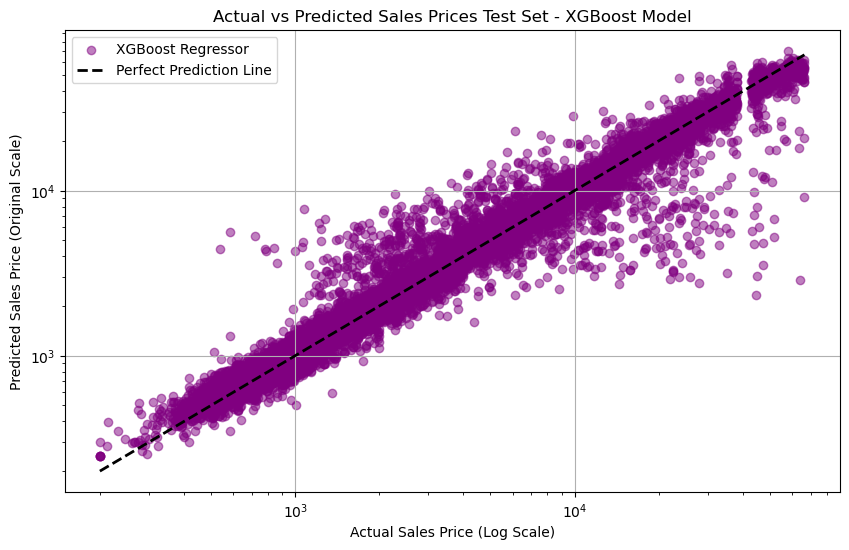

In [7]:
# 1. Ensure the 'result' folder exists
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)

# 2. Generate predictions (XGBoost typically takes the raw X_test)
# These predictions are in the log-transformed scale
y_test_pred_xgb_log = loaded_xgb.predict(X_test)

# 3. Convert predictions to original scale
y_test_pred_xgb = np.expm1(y_test_pred_xgb_log)
y_test_actual = np.expm1(y_test_log)

# 4. Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, y_test_pred_xgb, alpha=0.5, color='purple', label='XGBoost Regressor')

# Perfect Prediction Line
plt.plot([y_test_actual.min(), y_test_actual.max()], 
         [y_test_actual.min(), y_test_actual.max()], 'k--', lw=2, label='Perfect Prediction Line')

# Set logarithmic scale for both axes
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Actual Sales Price (Log Scale)')
plt.ylabel('Predicted Sales Price (Original Scale)')
plt.title('Actual vs Predicted Sales Prices Test Set - XGBoost Model')
plt.legend()
plt.grid(True)

# 5. Save the plot BEFORE plt.show()
xgb_plot_path = os.path.join(results_dir, 'xgb_actual_vs_predicted.png')
plt.savefig(xgb_plot_path, dpi=300, bbox_inches='tight')
print(f"XGBoost plot saved to: {xgb_plot_path}")

# 6. Show the plot
plt.show()

In [10]:
# 1. Calculate metrics
rmse_xgb = np.sqrt(mean_squared_error(y_test_actual, y_test_pred_xgb))
r2_xgb = r2_score(y_test_actual, y_test_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_test_actual, y_test_pred_xgb)

# 2. Print results in a clean format
print(f"{'XGBoost Performance Metrics':^40}")
print("="*40)
print(f"RMSE:     ${rmse_xgb:,.2f}")
print(f"R² Score:  {r2_xgb:.4f}")
print(f"MAPE:      {mape_xgb * 100:.2f}%")
print("="*40)

      XGBoost Performance Metrics       
RMSE:     $2,181.75
R² Score:  0.9312
MAPE:      10.41%
